# Preámbulo

In [2]:
import pandas as pd 
import shapely.geometry as geom
import geopandas as gpd
from simpledbf import Dbf5
import os
from unidecode import unidecode
import re
import numpy as np
from matplotlib import pyplot as plt

# Set locals for directories
working_dir = "/Users/upar/Library/CloudStorage/OneDrive-UniversidaddelosAndes/03 MONEY/CESED/ANDI"
data_dir = "/Users/upar/Library/CloudStorage/OneDrive-UniversidaddelosAndes/03 MONEY/CESED/ANDI/Datos"

# Test directories

os.listdir(working_dir)

['Datos',
 '.DS_Store',
 'Output',
 'UPZs que faltan.pdf',
 'Scripts',
 '.backups',
 'multiproposito.pdf']

# Spatial join crimes to localidades

## Crimes to points

In [3]:
delito_2021=pd.read_csv(f"{data_dir}/2-IntermediateData/GIS/6-Hurto a personas/Hurto a personas_2021.csv")
delito_2021.shape

(107533, 17)

In [5]:
delito_2021.columns,delito_2021.dtypes

(Index(['Unnamed: 0', 'year', 'armas', 'modalidad', 'dpto', 'mun', 'fecha',
        'edad', 'genero', 'hechos', 'hora', 'cod_dane', 'hora_24', 'lat', 'lon',
        'cantidad', 'Unnamed: 15'],
       dtype='object'),
 Unnamed: 0       int64
 year             int64
 armas           object
 modalidad       object
 dpto            object
 mun             object
 fecha           object
 edad           float64
 genero          object
 hechos           int64
 hora            object
 cod_dane         int64
 hora_24          int64
 lat            float64
 lon            float64
 cantidad         int64
 Unnamed: 15      int64
 dtype: object)

In [6]:
delito_2021=gpd.GeoDataFrame(delito_2021,
                 geometry=gpd.points_from_xy(delito_2021['lon'],delito_2021['lat']),
                 crs="EPSG:4326")

In [8]:
delito_2021.dtypes

Unnamed: 0        int64
year              int64
armas            object
modalidad        object
dpto             object
mun              object
fecha            object
edad            float64
genero           object
hechos            int64
hora             object
cod_dane          int64
hora_24           int64
lat             float64
lon             float64
cantidad          int64
Unnamed: 15       int64
geometry       geometry
dtype: object

In [7]:
# delito_2021.to_file("~/Downloads/hurtos_puntitos.gpkg", driver="GPKG")

## Read localidades geopackage

In [7]:
localidades = gpd.read_file(f"{data_dir}/2-IntermediateData/GIS/localidades_estrato_poblacion.gpkg")

In [8]:
localidades.head()

LocNombre           LocAAdmini       LocArea LocCodigo  \
0      ANTONIO NARIÑO  Acuerdo 117 de 2003  4.879543e+06        15   
1          TUNJUELITO  Acuerdo 117 de 2003  9.910940e+06        06   
2  RAFAEL URIBE URIBE  Acuerdo 117 de 2003  1.383408e+07        18   
3          CANDELARIA  Acuerdo 117 de 2003  2.060243e+06        17   
4      BARRIOS UNIDOS    Acuerdo 8 de 1977  1.190345e+07        12   

   SHAPE_Leng  SHAPE_Area  ESTRATO_mean  ESTRATO_median  ESTRATO_stddev  \
0    0.108973    0.000397      2.597360             3.0        0.983155   
1    0.210542    0.000807      2.085181             2.0        0.797298   
2    0.174513    0.001126      2.011214             2.0        0.900003   
3    0.067158    0.000168      1.575758             2.0        1.159858   
4    0.121180    0.000969      2.932780             3.0        1.128858   

   poblacion_loc_2018  poblacion_loc_2019  poblacion_loc_2020  \
0               79229               80095               81472   
1              171632              175481              178667   
2              364532              372981              380073   
3               17075               17345               17611   
4              133126              138316              143265   

   poblacion_loc_2021  poblacion_loc_2022  \
0               82201               82958   
1              180158              181476   
2              383960              386696   
3               17877               18143   
4              146876              150151   

                                            geometry  
0  MULTIPOLYGON (((-74.13075 4.59335, -74.12917 4...  
1  MULTIPOLYGON (((-74.13777 4.59489, -74.13165 4...  
2  MULTIPOLYGON (((-74.12803 4.59254, -74.12777 4...  
3  MULTIPOLYGON (((-74.06621 4.60317, -74.06620 4...  
4  MULTIPOLYGON (((-74.05725 4.68684, -74.06249 4...

## Join the layers/geodataframes

In [33]:
# check that both crs (projection) are the same
localidades.crs==delito_2021.crs

True

In [37]:
join=gpd.sjoin(delito_2021,localidades,how="inner", predicate='intersects')

In [40]:
join.columns

Index(['Unnamed: 0', 'year', 'armas', 'modalidad', 'dpto', 'mun', 'fecha',
       'edad', 'genero', 'hechos', 'hora', 'cod_dane', 'hora_24', 'lat', 'lon',
       'cantidad', 'Unnamed: 15', 'geometry', 'index_right', 'LocNombre',
       'LocAAdmini', 'LocArea', 'LocCodigo', 'SHAPE_Leng', 'SHAPE_Area',
       'ESTRATO_mean', 'ESTRATO_median', 'ESTRATO_stddev',
       'poblacion_loc_2018', 'poblacion_loc_2019', 'poblacion_loc_2020',
       'poblacion_loc_2021', 'poblacion_loc_2022'],
      dtype='object')

In [48]:
# Check that the join was successful 
join.cantidad.sum()
# It coincides with QGIS's spatial join!!! Epa!!

107496

In [64]:
d2021=join.groupby('LocCodigo')['cantidad'].agg('sum') #.reset_index()
d2021.name = "hurtos_personas_2021"

In [68]:
df=localidades.merge(d2021, left_on='LocCodigo', right_index=True)

In [70]:
df.columns

Index(['LocNombre', 'LocAAdmini', 'LocArea', 'LocCodigo', 'SHAPE_Leng',
       'SHAPE_Area', 'ESTRATO_mean', 'ESTRATO_median', 'ESTRATO_stddev',
       'poblacion_loc_2018', 'poblacion_loc_2019', 'poblacion_loc_2020',
       'poblacion_loc_2021', 'poblacion_loc_2022', 'geometry',
       'hurtos_personas_2021'],
      dtype='object')

# Creando tasa de hurto a personas

In [73]:
# df.sort_values(by='ESTRATO_mean')
df['Tasa x 100 mil hab.']=np.round(df['hurtos_personas_2021']/df['poblacion_loc_2021']*100000,2)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [Text(0, 0, 'ANTONIO NARIÑO'),
  Text(1, 0, 'TUNJUELITO'),
  Text(2, 0, 'RAFAEL URIBE URIBE'),
  Text(3, 0, 'CANDELARIA'),
  Text(4, 0, 'BARRIOS UNIDOS'),
  Text(5, 0, 'TEUSAQUILLO'),
  Text(6, 0, 'PUENTE ARANDA'),
  Text(7, 0, 'LOS MARTIRES'),
  Text(8, 0, 'USAQUEN'),
  Text(9, 0, 'CHAPINERO'),
  Text(10, 0, 'SANTA FE'),
  Text(11, 0, 'SAN CRISTOBAL'),
  Text(12, 0, 'USME'),
  Text(13, 0, 'CIUDAD BOLIVAR'),
  Text(14, 0, 'BOSA'),
  Text(15, 0, 'KENNEDY'),
  Text(16, 0, 'FONTIBON'),
  Text(17, 0, 'ENGATIVA'),
  Text(18, 0, 'SUBA')])

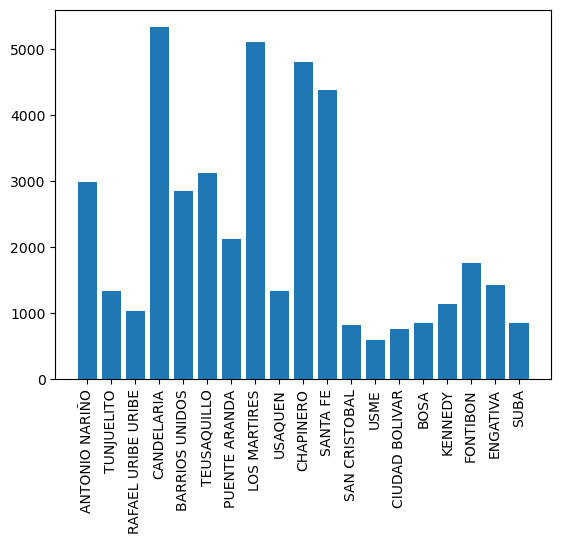

In [101]:
plt.bar(x=df['LocNombre'],height=df['Tasa x 100 mil hab.'])
plt.xticks(rotation = 90) 

<Axes: >

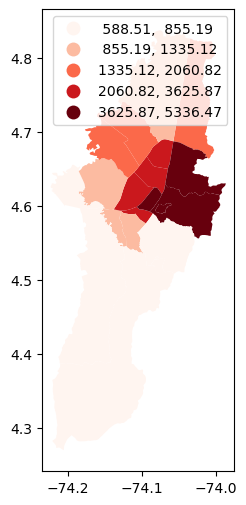

In [93]:
fig, ax = plt.subplots(figsize=(10, 6))
df.plot(
    ax=ax, column='Tasa x 100 mil hab.', legend=True,
    cmap="Reds", scheme="quantiles"
)

# ax.legend(loc='center')

## Graficando tasa

/var/folders/gh/2cf49j_x4q533sfszrhs7szc0000gn/T/ipykernel_39222/1805515786.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(df['LocNombre'], rotation=90)


Text(0, 0.5, 'Estrato promedio')

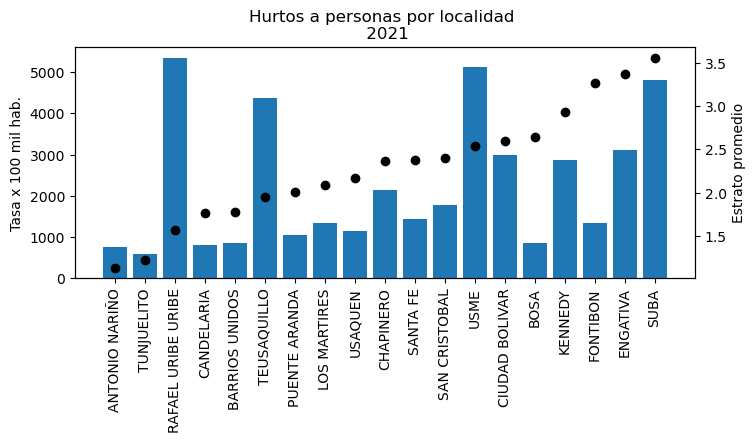

In [131]:
# Load Data -----------------------

# p=df.sort_values(by='ESTRATO_mean')[['LocNombre','ESTRATO_mean','Tasa x 100 mil hab.']]

# Plot crime rate and stratum -----------------------

fig, ax1 = plt.subplots(figsize=(8, 3))
ax2 = ax1.twinx()

ax1.set_title("Hurtos a personas por localidad \n 2021")

ax1.bar(x=p['LocNombre'],height=p['Tasa x 100 mil hab.'])
ax1.set_xticklabels(df['LocNombre'], rotation=90)
ax1.set_ylabel('Tasa x 100 mil hab.')
# Plot social stratum
ax2.scatter(x=p['LocNombre'], y=p['ESTRATO_mean'], color='black')
ax2.set_ylabel('Estrato promedio')

In [133]:
p['prop_tasa']=p['Tasa x 100 mil hab.']/(p['Tasa x 100 mil hab.'].sum())*100
p

LocNombre  ESTRATO_mean  Tasa x 100 mil hab.  prop_tasa
14      CIUDAD BOLIVAR      1.137058               759.58   1.780074
13                USME      1.221687               588.51   1.379172
3           CANDELARIA      1.575758              5336.47  12.506005
12       SAN CRISTOBAL      1.770648               817.08   1.914825
15                BOSA      1.776570               848.12   1.987567
11            SANTA FE      1.953668              4380.06  10.264661
2   RAFAEL URIBE URIBE      2.011214              1038.91   2.434683
1           TUNJUELITO      2.085181              1334.38   3.127116
16             KENNEDY      2.167882              1146.65   2.687172
6        PUENTE ARANDA      2.370959              2134.06   5.001165
18            ENGATIVA      2.378586              1426.85   3.343820
17            FONTIBON      2.405815              1767.84   4.142929
7         LOS MARTIRES      2.540166              5113.51  11.983499
0       ANTONIO NARIÑO      2.597360              2986.58   6.999043
19                SUBA      2.647280               859.91   2.015197
4       BARRIOS UNIDOS      2.932780              2858.87   6.699755
9              USAQUEN      3.269815              1338.08   3.135787
5          TEUSAQUILLO      3.373637              3123.08   7.318931
10           CHAPINERO      3.556424              4812.72  11.278598

## Graficando proporción de tasa

In [135]:
# Load Data -----------------------

# p=df.sort_values(by='ESTRATO_mean')[['LocNombre','ESTRATO_mean','prop_tasa']]

# Plot crime rate and stratum -----------------------

fig, ax1 = plt.subplots(figsize=(8, 3))
ax2 = ax1.twinx()

ax1.set_title("Hurtos a personas por localidad \n 2021")

ax1.bar(x=p['LocNombre'],height=p['prop_tasa'])
ax1.set_xticklabels(df['LocNombre'], rotation=90)
ax1.set_ylabel('prop_tasa')
# Plot social stratum
ax2.scatter(x=p['LocNombre'], y=p['ESTRATO_mean'], color='black')
ax2.set_ylabel('Estrato promedio')

/var/folders/gh/2cf49j_x4q533sfszrhs7szc0000gn/T/ipykernel_39222/2926119932.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(df['LocNombre'], rotation=90)


Text(0, 0.5, 'Estrato promedio')